In [1]:
import numpy as np 
import sys 
import matplotlib.pyplot as plt
import time
import scipy.stats as st
import scipy.cluster.vq as cvq
import multiprocessing as mp
import image_tools as it
from scipy.ndimage import imread


import numpy.ma as ma
import scipy.stats as st
import scipy.signal as si
from astropy.io import fits
from astropy.table import Table
import scipy.ndimage.morphology as morph
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
%reload_ext autoreload

import parameters
#import image_tools as it
import gibbs_sampler as gs
import fields_tools as ft
import seg_OTMF as sot

sys.path.insert(0,'./libext/MPDAF')
import mpdaf

from mpdaf.obj import WCS
from mpdaf.obj import WaveCoord
from mpdaf.obj import Image
from mpdaf.obj import Spectrum
from mpdaf.obj import Cube


from mpdaf.sdetect import Source, SourceList
from mpdaf.sdetect import Catalog

In [2]:
# recup catalogue

cat = Catalog.read('./data/mosaic_lya_sources/mosaic_c031_e028_withz.fits')

cat_lya=cat[cat['TYPE']==6]

print 'Total de %.0f LAE dans la mosaïque.'%len(cat_lya)

Total de 745 LAE dans la mosaïque.


/home/miv/courbot/anaconda/lib/python2.7/site-packages/astropy/table/column.py:1095: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


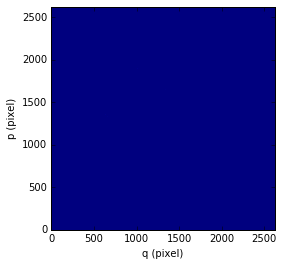

In [6]:
im = Image('data/mosaic_lya_sources/hlsp_xdf_hst_acswfc-30mas_hudf_f814w_v1_sci.fits')



In [9]:
liste_restrict = (63,   68,   82,  102,  109,  126,  148,  153,  168,  171,  183, 214,  218,  262,  263,  298,
            299,  324,  364,  399,  400,  489, 579,  587,  590,  606,  619,  736, 1059, 1087, 1113, 1228,
            1445, 1446, 1477, 1478, 1486, 1581, 1583, 1593, 1665, 1670, 1711, 1714, 1723, 1724, 1726, 1737,
            1756, 1843, 1864, 1931, 1969, 1971, 1991, 2049, 2103, 2132, 2155, 2171, 2178, 2211, 2217, 2264,
            2333, 2335, 2363, 2389, 2403, 2467, 2495, 2515, 2522, 2547, 2598, 2634, 2672, 2687, 2727, 2733,
            2817, 2847, 2861, 2865, 2885, 3027, 3055, 3089, 3138, 3156, 3219, 3234, 3238, 3240, 3242, 3257,
            3286, 3305, 3329, 3335, 3421, 3426, 3480, 3484, 3492, 3494, 3585, 3589, 3611, 3634, 3672, 3723,
            3746, 3797, 3858, 3930, 3933, 3946, 4141, 4205, 4231, 4333, 4381, 4515, 4598, 4661, 4755, 4776,
            4802, 4842, 4870, 5027, 5225, 5281, 5308, 5439, 5452, 5566, 5949, 6101, 6341, 6372, 6375, 6376,
            6389, 6391, 6398, 6423, 6430, 6447, 6457, 6458, 6459, 6483, 6485, 6489, 6492, 6497, 6507, 6520,
            6537, 6550, 6565, 6570, 6572, 6578)

liste_udf10 = (63,  78, 106, 109, 148, 149, 153, 157, 171, 180, 183, 214, 242, 279, 308, 357, 364, 374, 378, 
                400, 417, 467, 547, 559, 663, 837)

#liste_50 = (63,102,109,126,148,171,218,262,)
#liste_50 = (364,400,590,736,1446,1714)
#liste_50 = (1737,1756, 1843,1864,1969,1971,1991,2155,2171,2178,2217,2335,2467,2515,2547,2598,2634,2727,2885,)
#liste_40 = (1583,1593, 736,590,1446,3219,3242,3286,3305,3242,3492,3494,3589,3611,3672,3723,3746,3797,3858,3946,4141,1991,2178,1843,2217)

#liste_40 = ()

#liste_lam_court = (399,579,587,1670,1723,1724,2132,2264,2403,3089,3238,3634,3930,6101,6457,6507, 3305,)

#liste_40 = (4802,5439,5452,6341,6375,6376,6389,6423,6430,6447,6483,6489,6492,6520,6550,6565, 399,579,587,1723,1724,2132,)

#liste_50=(3257,3426,4205,4515,4598,4755,4776,5225,
#          5308, 3219,4141,3286,3634,6376,1724,)

#liste_100=(68,324,364,1726,2817,1670,2132,)
#liste_70 = (171,1478,1581,2672,2687,)

#liste_100 = (1670,2132,1726)
#liste_50 = (364,1726)
#liste_70=(68,2817)
#liste_40 = (3257,4755,5225,3219,4141,6376,1478,)
#
#liste_lam_10 = (4333,)
#liste_lam_plus = (6101,3305)

liste_echec = (308,606,1665,2103,2847,3138,3156,3234,3240,3335,3484,
               3933,1864,4661,4842,4870,5027,5566,5949,6398, 1991,
               2264,3089,3238,3930,6457,6507,5452,6341,6389,6423,
              6430,6447,6483,6489,6565,579,587,1670,3426,4776,1670,
              6101,3305)

liste_mos_seule = np.sort(list(set(liste_restrict) - set(liste_udf10)))

liste_tout = np.append(liste_mos_seule,liste_udf10)

print 'Total de %.0f objets retenus dans la mosaïque.'%(len(liste_tout)-len(liste_echec))
print len(liste_mos_seule)+len(liste_udf10)

Total de 139 objets retenus dans la mosaïque.
183


In [10]:
sourcelist = list()
numobj = 0
listez = list()
#liste_id = cat_lya['ID']
for id in liste_tout:
    try:
        if id not in liste_echec:
            
            if id in liste_udf10:
                src= Source.from_file('./data/udf10_lya_sources_v0/udf10_'+str(id)+'.fits')
            else:
                
                src= Source.from_file('./data/mosaic_lya_sources/mosaic_'+str(id)+'.fits')
            sourcelist.append(src)

            numobj+=1

            listez.append(src.z[0][0])
    except:
        pass

In [ ]:
print np.max(listez)

In [36]:
#####
# Fabrication de toutes les images
#####


import numpy.ma as ma
import matplotlib
import scipy.ndimage.morphology as morph
from skimage import measure

# dictionnaire avec toutes les images, tous les z
toutes_im = {}
disp_muse=0
if disp_muse:
    im_cube = Image('data/IMAGE_UDF-MOSAIC.fits')
    
else:
    im_hst = Image('data/mosaic_lya_sources/hlsp_xdf_hst_acswfc-30mas_hudf_f814w_v1_sci.fits')
    
    im_cube = im_hst.rebin(4).rotate(-42)
    
wcs_ref = im_cube.wcs
decal = 25
shapemax = np.array([im_cube.data.data.shape[0]+2*decal, im_cube.data.data.shape[1]+2*decal])


nb_obj = 0

for src in sourcelist:
        
        try:
            im = src.images['SEG_HMF']
            
            #if src.id in liste_udf10:

                

            imbin = im.data.data==1

            # a) pixel à 1 au centroide de l'image initiale
            #center = np.round(measure.regionprops(imbin)[0].centroid).astype(int)

            center_radec = np.array([src.dec,src.ra])

            center_pix =  im.wcs.sky2pix(center_radec)[0].astype(int)

            cpix = np.zeros_like(imbin)
            cpix[center_pix[0],center_pix[1]] = 1

            # b) on ne garde dans la segmentation que les pixels connexes au pixel central
            im2 = morph.binary_propagation(cpix,mask=imbin)

            im.data = im2


            im_align = im.align_with_image(im_cube)
            im_align.data = im_align.data > 0.5

            image_tout = im_align.data

            image_tout = ma.masked_array(image_tout,mask=image_tout==0)
            #else:
            
            #    wcs_loc = im.wcs
            #    z = src.z[0][0]
#
            #    imbin = im.data.data==1
#
            #    # a) pixel à 1 au centroide de l'image initiale
            #    #center = np.round(measure.regionprops(imbin)[0].centroid).astype(int)
#
            #    center_radec = np.array([src.dec,src.ra])
#
            #    center_pix =  wcs_loc.sky2pix(center_radec)[0].astype(int)
            #    #center = np.array()  start_pix = wcs_loc.sky2pix(start_radec)[0].astype(int)
            #    cpix = np.zeros_like(imbin)
            #    cpix[center_pix[0],center_pix[1]] = 1
#
            #    # b) on ne garde dans la segmentation que les pixels connexes au pixel central
            #    im2 = morph.binary_propagation(cpix,mask=imbin)
#
            #    im.data = im2
#
#
            #    start_radec, end_radec = im.get_start(), im.get_end()
            #    start_pix = wcs_ref.sky2pix(start_radec)[0].astype(int)
            #    end_pix = start_pix + im.data.data.shape
#
            #    #znorm = (z-zmin_tout)/(zmax_tout-zmin_tout)
#
            #    image_tout = np.zeros(shape=shapemax)
            #    image_tout[decal+start_pix[0]:decal+end_pix[0], decal+start_pix[1]:decal+end_pix[1]] = im.data.data
            #    image_tout = ma.masked_array(image_tout,mask=image_tout==0)
#
            #    # crop aux dimensions initiales
            #    image_tout = image_tout[decal:-decal,decal:-decal]
#
            toutes_im[str(src.id)] = image_tout

            nb_obj+=1
        except:
            print 'erreur obj %.0f'%src.id
            pass
  
    
 

erreur obj 2049
erreur obj 6570


In [31]:

deb = im_cube.wcs.sky2pix(im_udf10.get_start())[0]
fin = im_cube.wcs.sky2pix(im_udf10.get_end())[0]
print deb, fin

print im_udf10.get_start()
print im_udf10.get_end()
print im_udf10.get_range()


[ 578.97791557  346.31703628] [ 602.09759635  800.39925629]
[-27.78771333  53.17127889]
[-27.76987853  53.15106148]
[-27.78771333  53.15105817 -27.76987853  53.17127889]


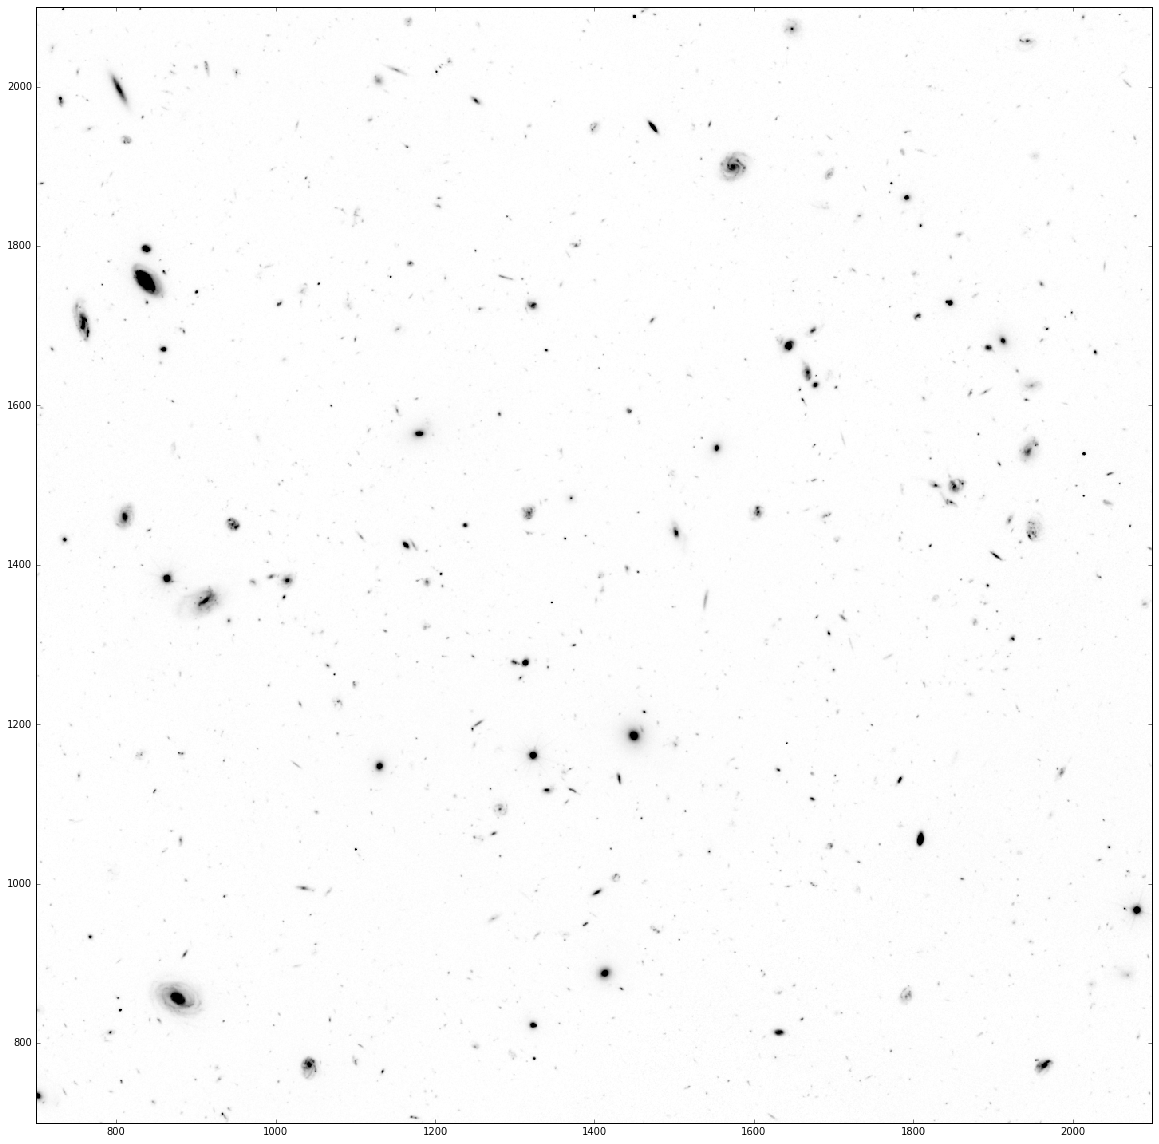

In [43]:
plt.figure(figsize=(20,20))
im_cube.plot(vmin=0,vmax=me+3*std,cmap=cm_gr,show_xlabel=False, show_ylabel=False)

plt.xlim(700,2100)
plt.ylim(700,2150)
plt.show()

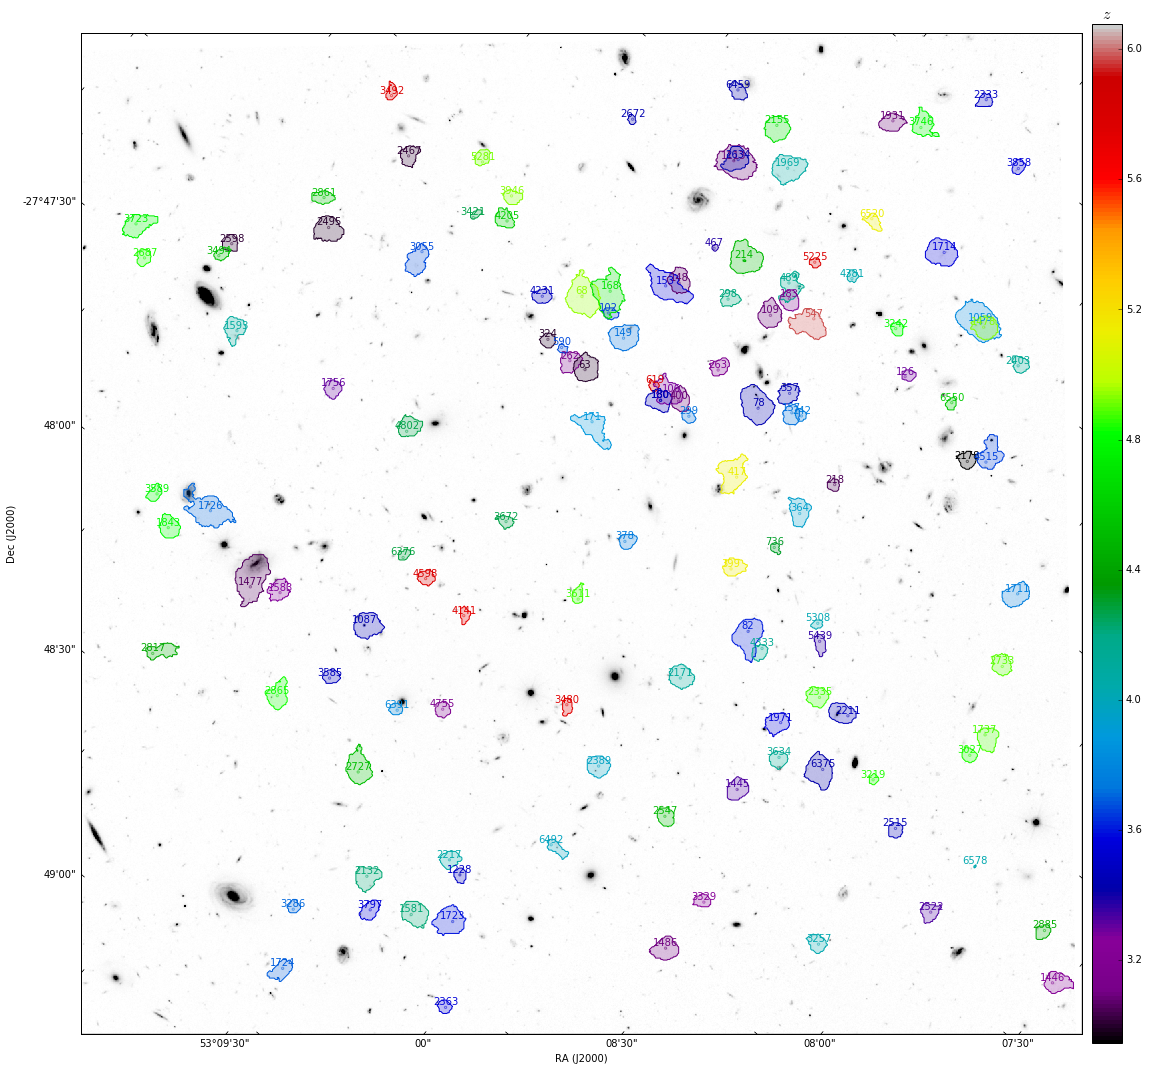

In [45]:
import numpy.ma as ma
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

#im_cube = Image('data/IMAGE_UDF-MOSAIC.fits')
im_udf10 = Image('data/IMAGE_UDF-10.fits')
im_hst = Image('data/mosaic_lya_sources/hlsp_xdf_hst_acswfc-30mas_hudf_f814w_v1_sci.fits')
#im_hst_rebin = im_hst.rebin(4).rotate(-42)

disp_muse = 0

if disp_muse:
    im_cube = Image('data/IMAGE_UDF-MOSAIC.fits')
else:
    im_cube = im_hst.rebin(4).rotate(-42)




im_udf10_align = im_udf10.align_with_image(im_cube)

im_udf10_align.get_start

cm_gr = plt.cm.gray_r
cm_gr.set_bad('w',1.)

zmin_tout = np.min(listez)#cat_lya['Z_MUSE'].min()
zmax_tout = np.max(listez)+0.1#cat_lya['Z_MUSE'].max()+0.1

gs = gridspec.GridSpec(1,2,width_ratios=[100,3])

fig = plt.figure(figsize=(16,15))

cm_r = plt.cm.nipy_spectral
decal = 25
shapemax = np.array([im_cube.data.data.shape[0]+2*decal, im_cube.data.data.shape[1]+2*decal])


ax1 = fig.add_subplot(gs[0],projection=im_cube.wcs.wcs)
ax1.set_xlabel('RA (J2000)')
ax1.set_ylabel('Dec (J2000)')

lon = ax1.coords[0] ; lon.set_ticks(number=10) ; #lon.set_major_formatter('dd:mm:ss')
lat = ax1.coords[1] ; lat.set_ticks(number=10)

### Colorbar
ax2 = fig.add_subplot(gs[1])

dumb = zmin_tout * np.ones_like(im_cube.data.data) ; dumb[500,500] = zmax_tout
im_dumb = im_cube.copy() ; im_dumb.data = dumb ; im_dumb.mask = im_cube.mask

i = im_dumb.plot(ax=ax1,cmap=cm_r,show_xlabel=False,show_ylabel=False)#,colorbar='v')

plt.colorbar(i,cax=ax2)

# image(s) au centre

#im_dumb.plot(ax=ax,cmap=cm_r,colorbar='v')
if disp_muse:
    im_cube.plot(ax=ax1,vmin=0,vmax=5,cmap=cm_gr,show_xlabel=False, show_ylabel=False)
    cm10 = matplotlib.cm.get_cmap('gray_r'); cm10.set_bad('w',0.)
    im_udf10_align.plot(ax=ax1,vmin=0,vmax=5,cmap=cm10,show_xlabel=False, show_ylabel=False)

    cont_udf10  = im_udf10_align.data.mask
    ax1.contour(morph.binary_opening(cont_udf10),levels=(0.5,),linestyles='dotted',colors='k',antialiased=True)
else:
    me, std = im_cube.data.data.mean(),im_hst_rebin.data.data.std()

    im_cube.plot(ax=ax1,vmin=0,vmax=me+3*std,cmap=cm_gr,show_xlabel=False, show_ylabel=False)
    
    ax1.set_ylim(650,2150)
    ax1.set_xlim(650,2150)
    
    cm10 = matplotlib.cm.get_cmap('gray_r'); cm10.set_bad('w',0.)
    #im_udf10_align.plot(ax=ax1,vmin=0,vmax=5,cmap=cm10,show_xlabel=False, show_ylabel=False)
    


lgd = plt.gca()
lgd.set_title('$z$',fontsize=16)


cm = matplotlib.cm.get_cmap('nipy_spectral')

wcs_ref = im_cube.wcs

nb_mos,nb_udf10 = 0,0

for src in sourcelist:
    try:



        image_tout = toutes_im[str(src.id)]
        z = src.z[0][0]

        znorm = (z-zmin_tout)/(zmax_tout-zmin_tout)

        col = cm(znorm)
        if disp_muse:
            cat[cat['ID']==src.id].plot_id(ax1,im_cube.wcs,col=col)
        else: 
            cat[cat['ID']==src.id].plot_id(ax1,im_cube.wcs,col=col)
        ax1.contourf(image_tout,1, colors=(cm(znorm),),alpha=0.25)
        ax1.contour(image_tout.data,1, colors=(cm(znorm),))#,linewidths=1.5)
        
        if src.id in liste_mos_seule:
            nb_mos+=1
        else:
            nb_udf10+=1
    except:
        pass    
 
    
plt.tight_layout()
plt.subplots_adjust(left=0.07,bottom=0.03)
if disp_muse:
    plt.savefig('./data/mosaic_lya_sources/graphic.pdf')
else:
    plt.savefig('./data/mosaic_lya_sources/graphic_with_hst.pdf')

array([-27.72966106,  53.15880614])

In [12]:
zmax_tout-zmin_tout

3.1320099999999997

In [70]:
print nb_mos, nb_udf10

107 20


In [10]:
########################################
# Calculs de stats diverses
########################################
from skimage import measure
import scipy.ndimage.morphology as morph


surfaces = np.array([])
perims = np.array([])
redshifts = np.array([])
excen = np.array([])
ras = np.array([])
decs = np.array([])
largeurs = np.array([])
hauteurs = np.array([])
longueurs = np.array([])

ind_bords = np.array([])

id_tous = np.array([])
for src in sourcelist:
    try:
        #src= Source.from_file('./data/udf10_lya_sources_v0/udf10_'+str(id)+'.fits')
        im = src.images['SEG_HMF'].data>0
        
        
        # a) pixel à 1 au centroide de l'image initiale
        center = np.round(measure.regionprops(im)[0].centroid).astype(int)
        cpix = np.zeros_like(im)
        cpix[center[0],center[1]] = 1

        # b) on ne garde dans la segmentation que les pixels connexes au pixel central
        im2 = morph.binary_propagation(cpix,mask=im)
        
        #c) Extraction des mesures
        props = measure.regionprops(im2)[0]
        if props.area > 1:
            

            perims = np.append(perims,props.perimeter)
            surfaces = np.append(surfaces,props.area)
            excen = np.append(excen,props.eccentricity)

            #print src.id,props.area

            redshifts = np.append(redshifts,(src.z[0][0]))
            ras = np.append(ras,src.ra)
            decs = np.append(decs,src.dec)
            
            largeurs = np.append(largeurs,im.shape[0])
            hauteurs = np.append(hauteurs,im.shape[1])
            longueurs = np.append(longueurs, src.spectra['SP_SEM'].shape[0])
            
            id_tous = np.append(id_tous,src.id)

            
    except:
        pass
    
mes = 4*np.pi*surfaces/(perims**2) 

In [8]:
print largeurs.min(),  largeurs.mean(), largeurs.max()
print 'Tailles en Arcsec. min = %.2f, mean = %.2f, max = %.2f'%(0.2*hauteurs.min(),  0.2*hauteurs.mean(), 0.2*hauteurs.max())

print 'Largeur spectrales en Ang. min = %.2f, mean = %.2f, max = %.2f'%(1.25*longueurs.min(),  1.25*longueurs.mean(), 1.25*longueurs.max())

40.0 54.7627118644 100.0
Tailles en Arcsec. min = 8.00, mean = 11.00, max = 20.00
Largeur spectrales en Ang. min = 13.75, mean = 25.69, max = 26.25


In [12]:
id_tous

array([   68.,    82.,   102.,   126.,   168.,   218.,   262.,   263.,
         298.,   299.,   399.,   489.,   619.,   736.,  1059.,  1087.,
        1113.,  1228.,  1445.,  1446.,  1477.,  1478.,  1486.,  1581.,
        1583.,  1593.,  1711.,  1714.,  1723.,  1724.,  1726.,  1737.,
        1756.,  1843.,  1931.,  1969.,  1971.,  2155.,  2171.,  2178.,
        2211.,  2217.,  2333.,  2335.,  2363.,  2389.,  2403.,  2467.,
        2495.,  2515.,  2522.,  2547.,  2598.,  2634.,  2672.,  2687.,
        2727.,  2733.,  2817.,  2861.,  2865.,  2885.,  3027.,  3055.,
        3219.,  3242.,  3257.,  3286.,  3329.,  3480.,  3492.,  3585.,
        3589.,  3611.,  3634.,  3672.,  3723.,  3746.,  3797.,  3858.,
        3946.,  4141.,  4205.,  4231.,  4333.,  4381.,  4515.,  4598.,
        4755.,  4802.,  5281.,  5308.,  5439.,  6375.,  6391.,  6459.,
        6492.,  6550.,    63.,    78.,   106.,   109.,   148.,   149.,
         153.,   157.,   171.,   180.,   183.,   214.,   357.,   378.,
      

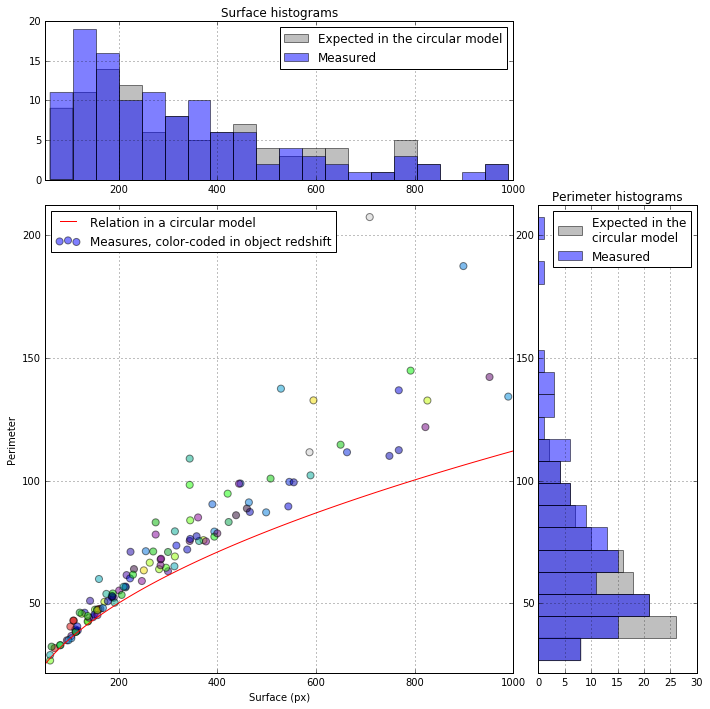

In [9]:
s_range = np.arange(0,100+s0.max(),10)
p_circle = np.sqrt(4*np.pi*s0)
p_ref = np.sqrt(4*np.pi*s_range)

#p_range = np.arange(p0.min(),p0.max(),(p0.max()-p0.min())/600.)
s_circle = p0**2/(4*np.pi)#np.sqrt(4*np.pi*s_range)


left, width = 0.07, 0.65
bottom, height = 0.07, 0.65
bottom_h = left_h = left + width + 0.035

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.22]
rect_histy = [left_h, bottom, 0.22, height]

# start with a rectangular Figure
f=plt.figure(1, figsize=(10, 10))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)



axScatter.plot(s_range,p_ref,'-r',label='Relation in a circular model')
axScatter.scatter(s0, p0, c=r0,s=50, alpha=0.5,label='Measures, color-coded in object redshift'); plt.spectral()


axScatter.set_ylabel('Perimeter'); axScatter.set_xlabel('Surface (px)')
axScatter.legend(loc='upper left')
axScatter.grid()
axScatter.set_xlim((s0.min()-10,s0.max()+10))
axScatter.set_ylim((p0.min()-5,p0.max()+5))

nb_bin = 20.

binwidth = (s0.max()-s0.min())/nb_bin
binsx = np.arange(s0.min(),s0.max()+binwidth,binwidth)
axHistx.hist(s_circle,bins=binsx,alpha=0.5,facecolor='gray',normed=0,label='Expected in the circular model')
axHistx.hist(s0,bins=binsx,alpha=0.5,normed=0,facecolor='blue',label='Measured')

axHistx.set_title('Surface histograms')
axHistx.legend()
axHistx.set_xlim(axScatter.get_xlim())
axHistx.grid()


binwidth = (p0.max()-p0.min())/nb_bin
binsy = np.arange(p0.min(),p0.max()+binwidth,binwidth)
axHisty.hist(p_circle,bins=binsy,alpha=0.5,orientation='horizontal',facecolor='gray',normed=0,label='Expected in the\ncircular model')
axHisty.hist(p0,bins=binsy,alpha=0.5,orientation='horizontal',normed=0,facecolor='blue',label='Measured')

#axHisty.hist(p0,15,alpha=0.5,orientation='horizontal')
axHisty.set_ylim(axScatter.get_ylim())
axHisty.set_title('Perimeter histograms')
axHisty.legend()
axHisty.grid()


plt.show()

f.savefig('./data/udf10_lya_sources_v0/perimeters_vs_surface.pdf')
#plt.tight_layout()

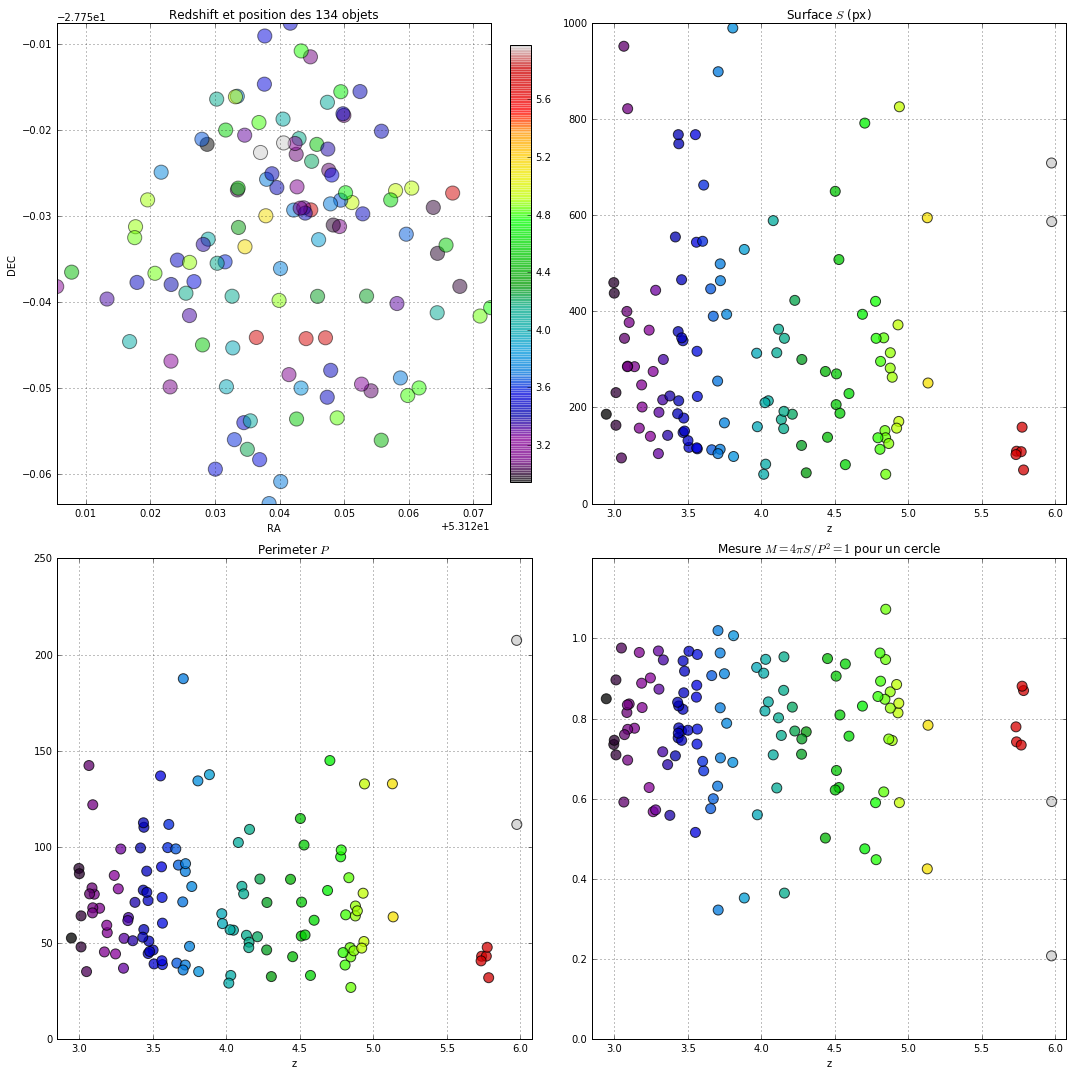

In [7]:
plt.figure(figsize=(15,15))
nb_li = 2
nb_col = 2

ind_bords = np.zeros_like(redshifts)
zmin = redshifts.min()-0.1 ; zmax = redshifts.max()+0.1


r0 = redshifts[ind_bords==0] ; r1 = redshifts[ind_bords==1]
s0 = surfaces[ind_bords==0] ; s1 = surfaces[ind_bords==1]
p0 = perims[ind_bords==0] ; p1 = perims[ind_bords==1]
m0 = mes[ind_bords==0] ; m1 = mes[ind_bords==1]

plt.subplot(nb_li,nb_col,1)
plt.scatter(ras,decs,c=redshifts,s=200,alpha=0.5); plt.spectral();plt.colorbar(fraction=0.046,pad=0.04)
plt.xlabel('RA'); plt.ylabel('DEC');plt.title('Redshift et position des %.0f objets'%numobj)
plt.xlim(ras.min(),ras.max()) ; plt.ylim(decs.min(),decs.max()) ; plt.grid()

plt.subplot(nb_li,nb_col,2)
plt.scatter(r0, s0, c=r0,s=100, alpha=0.75); plt.spectral()
#plt.scatter(r1,s1,c=r1,s=100,marker='^', alpha=0.75); plt.spectral()
plt.xlabel('z'); plt.title('Surface $S$ (px)')
plt.ylim(0,surfaces.max()+10) ; plt.xlim(zmin,zmax) ; plt.grid()

plt.subplot(nb_li,nb_col,3)
plt.scatter(r0, p0, c=r0,s=100, alpha=0.75); plt.spectral()
#plt.scatter(r1,p1,c=r1,s=100,marker='^', alpha=0.75); plt.spectral()
plt.xlabel('z'); plt.title('Perimeter $P$')
plt.ylim(0,None) ; plt.xlim(zmin,zmax) ; plt.grid()




plt.subplot(nb_li,nb_col,4)
#plt.scatter(4*np.pi*s0, p0**2, c=r0,s=75, alpha=0.75); plt.spectral()
#plt.grid()
#plt.xlim(0,10000)
#plt.ylim(0,10000)
#plt.xlabel('Surface $S$'); plt.ylabel('Perimeter $P$')

#plt.title('Mesure $M=4\pi S / P^2 = 1$ pour un cercle')

plt.scatter(r0, m0, c=r0,s=100, alpha=0.75); plt.spectral()
#plt.scatter(r1,m1,c=r1,s=100,marker='^', alpha=0.75); plt.spectral()
plt.xlabel('z'); plt.title('Mesure $M=4\pi S / P^2 = 1$ pour un cercle')
plt.ylim(0,1.2) ; plt.xlim(zmin,zmax) ; plt.grid()


plt.tight_layout()

#plt.savefig('./data/udf10_lya_sources_v0/mesures_preliminaires.pdf')

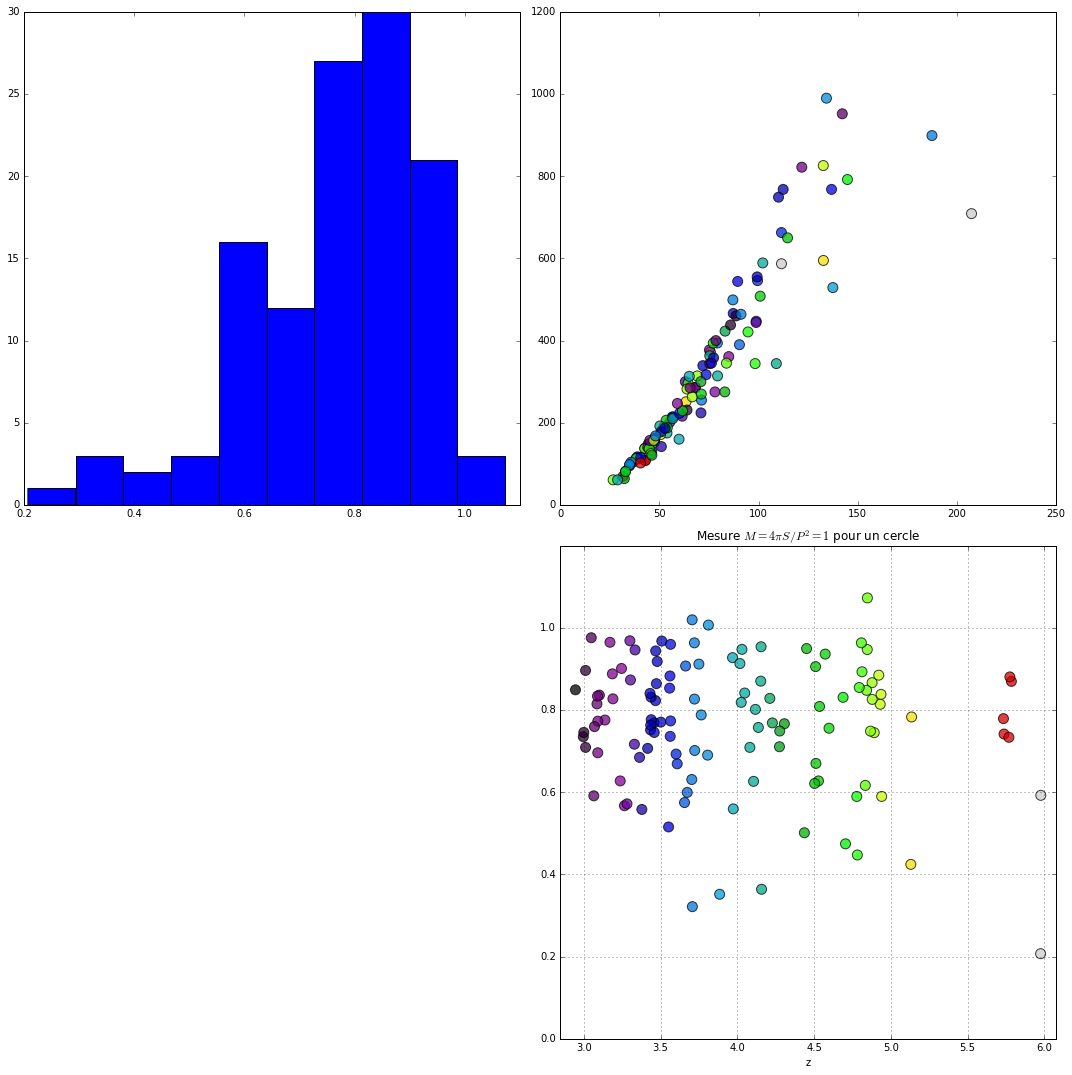

In [8]:
plt.figure(figsize=(15,15))
nb_li = 2
nb_col = 2

ind_bords = np.zeros_like(redshifts)
zmin = redshifts.min()-0.1 ; zmax = redshifts.max()+0.1


r0 = redshifts[ind_bords==0] ; r1 = redshifts[ind_bords==1]
s0 = surfaces[ind_bords==0] ; s1 = surfaces[ind_bords==1]
p0 = perims[ind_bords==0] ; p1 = perims[ind_bords==1]
m0 = mes[ind_bords==0] ; m1 = mes[ind_bords==1]

plt.subplot(nb_li,nb_col,1)
plt.hist(m0,10)
#plt.xlabel('RA'); plt.ylabel('DEC');plt.title('Circularity')
#plt.xlim(ras.min(),ras.max()) ; plt.ylim(decs.min(),decs.max()) ; plt.grid()

plt.subplot(nb_li,nb_col,2)
plt.scatter(p0, s0, c=r0,s=100, alpha=0.75); plt.spectral()
#plt.scatter(r1,s1,c=r1,s=100,marker='^', alpha=0.75); plt.spectral()
#plt.xlabel('z'); plt.title('Surface $S$ (px)')
#plt.ylim(0,surfaces.max()+10) ; plt.xlim(zmin,zmax) ; plt.grid()

#plt.subplot(nb_li,nb_col,3)
#plt.scatter(r0, p0, c=r0,s=100, alpha=0.75); plt.spectral()
##plt.scatter(r1,p1,c=r1,s=100,marker='^', alpha=0.75); plt.spectral()
#plt.xlabel('z'); plt.title('Perimeter $P$')
#plt.ylim(0,None) ; plt.xlim(zmin,zmax) ; plt.grid()
#
#


plt.subplot(nb_li,nb_col,4)
#plt.scatter(4*np.pi*s0, p0**2, c=r0,s=75, alpha=0.75); plt.spectral()
#plt.grid()
#plt.xlim(0,10000)
#plt.ylim(0,10000)
#plt.xlabel('Surface $S$'); plt.ylabel('Perimeter $P$')

#plt.title('Mesure $M=4\pi S / P^2 = 1$ pour un cercle')

plt.scatter(r0, m0, c=r0,s=100, alpha=0.75); plt.spectral()
#plt.scatter(r1,m1,c=r1,s=100,marker='^', alpha=0.75); plt.spectral()
plt.xlabel('z'); plt.title('Mesure $M=4\pi S / P^2 = 1$ pour un cercle')
plt.ylim(0,1.2) ; plt.xlim(zmin,zmax) ; plt.grid()


plt.tight_layout()

#plt.savefig('./data/udf10_lya_sources_v0/mesures_preliminaires.pdf')

In [12]:
s0

array([ 826.,  663.,  112.,  104.,  792.,   95.,  285.,  201.,  186.,
        113.,  251.,  344.,   70.,   64.,  990.,  466.,  822.,  117.,
        300.,  361.,  952.,  372.,  377.,  423.,  275.,  314.,  394.,
        544.,  546.,  255.,  899.,  314.,  190.,  296.,  286.,  589.,
        317.,  394.,  363.,  186.,  339.,  214.,  131.,  282.,  114.,
        313.,  175.,  231.,  460.,  148.,  216.,  206.,  163.,  358.,
        214.,  152.,  508.,  263.,  275.,  188.,  345.,  138.,  137.,
        390.,   61.,  113.,  210.,  104.,  140.,  109.,  108.,  151.,
        137.,  125.,  192.,  121.,  421.,  344.,  223.,  116.,  171.,
        102.,  229.,  178.,  156.,   82.,  447.,  159.,  157.,  300.,
        157.,   61.,  142.,  555.,   98.,  187.,  160.,   81.,  438.,
        749.,  444.,  400.,  344.,  499.,  768.,  464.,  529.,  345.,
        247.,  650.,  768.,  168.,  285.,  595.,  224.,  587.,  270.,  709.])

In [19]:
p0

array([ 132.64570696,  111.56854249,   39.38477631,   36.72792206,
        144.81727984,   34.97056275,   67.9411255 ,   55.24873734,
         53.11269837,   38.38477631,   63.45584412,  108.98275606,
         31.79898987,   32.38477631,  134.2314934 ,   87.254834  ,
        121.81118318,   38.97056275,   63.11269837,   85.01219331,
        142.22539674,   75.76955262,   75.254834  ,   83.14823228,
         78.04772721,   79.35533906,   79.254834  ,   89.49747468,
         99.49747468,   71.254834  ,  187.40916293,   69.11269837,
         52.28427125,   64.52691193,   68.18376618,  102.15432893,
         73.56244584,   77.18376618,   75.42640687,   52.45584412,
         71.9411255 ,   56.52691193,   46.21320344,   63.9411255 ,
         38.627417  ,   65.11269837,   53.87005769,   63.9766594 ,
         88.66904756,   44.38477631,   61.52691193,   53.45584412,
         47.79898987,   77.35533906,   56.87005769,   47.45584412,
        100.84671709,   66.59797975,   83.01219331,   54.04163

In [13]:
import numpy as np

liste_id = np.array([   68.,    82.,   102.,   126.,   168.,   218.,   262.,   263.,
         298.,   299.,   399.,   489.,   619.,   736.,  1059.,  1087.,
        1113.,  1228.,  1445.,  1446.,  1477.,  1478.,  1486.,  1581.,
        1583.,  1593.,  1711.,  1714.,  1723.,  1724.,  1726.,  1737.,
        1756.,  1843.,  1931.,  1969.,  1971.,  2155.,  2171.,  2178.,
        2211.,  2217.,  2333.,  2335.,  2363.,  2389.,  2403.,  2467.,
        2495.,  2515.,  2522.,  2547.,  2598.,  2634.,  2672.,  2687.,
        2727.,  2733.,  2817.,  2861.,  2865.,  2885.,  3027.,  3055.,
        3219.,  3242.,  3257.,  3286.,  3329.,  3480.,  3492.,  3585.,
        3589.,  3611.,  3634.,  3672.,  3723.,  3746.,  3797.,  3858.,
        3946.,  4141.,  4205.,  4231.,  4333.,  4381.,  4515.,  4598.,
        4755.,  4802.,  5281.,  5308.,  5439.,  6375.,  6391.,  6459.,
        6492.,  6550.,    63.,    78.,   106.,   109.,   148.,   149.,
         153.,   157.,   171.,   180.,   183.,   214.,   357.,   378.,
         400.,   417.,   467.,   547.,   559.,   837.])

liste_surface = np.array([ 826.,  663.,  112.,  104.,  792.,   95.,  285.,  201.,  186.,
        113.,  251.,  344.,   70.,   64.,  990.,  466.,  822.,  117.,
        300.,  361.,  952.,  372.,  377.,  423.,  275.,  314.,  394.,
        544.,  546.,  255.,  899.,  314.,  190.,  296.,  286.,  589.,
        317.,  394.,  363.,  186.,  339.,  214.,  131.,  282.,  114.,
        313.,  175.,  231.,  460.,  148.,  216.,  206.,  163.,  358.,
        214.,  152.,  508.,  263.,  275.,  188.,  345.,  138.,  137.,
        390.,   61.,  113.,  210.,  104.,  140.,  109.,  108.,  151.,
        137.,  125.,  192.,  121.,  421.,  344.,  223.,  116.,  171.,
        102.,  229.,  178.,  156.,   82.,  447.,  159.,  157.,  300.,
        157.,   61.,  142.,  555.,   98.,  187.,  160.,   81.,  438.,
        749.,  444.,  400.,  344.,  499.,  768.,  464.,  529.,  345.,
        247.,  650.,  768.,  168.,  285.,  595.,  224.,  587.,  270.,  709.])



liste_perimetre = np.array([ 132.64570696,  111.56854249,   39.38477631,   36.72792206,
        144.81727984,   34.97056275,   67.9411255 ,   55.24873734,
         53.11269837,   38.38477631,   63.45584412,  108.98275606,
         31.79898987,   32.38477631,  134.2314934 ,   87.254834  ,
        121.81118318,   38.97056275,   63.11269837,   85.01219331,
        142.22539674,   75.76955262,   75.254834  ,   83.14823228,
         78.04772721,   79.35533906,   79.254834  ,   89.49747468,
         99.49747468,   71.254834  ,  187.40916293,   69.11269837,
         52.28427125,   64.52691193,   68.18376618,  102.15432893,
         73.56244584,   77.18376618,   75.42640687,   52.45584412,
         71.9411255 ,   56.52691193,   46.21320344,   63.9411255 ,
         38.627417  ,   65.11269837,   53.87005769,   63.9766594 ,
         88.66904756,   44.38477631,   61.52691193,   53.45584412,
         47.79898987,   77.35533906,   56.87005769,   47.45584412,
        100.84671709,   66.59797975,   83.01219331,   54.04163056,
         83.84062043,   42.72792206,   42.627417  ,   90.39696962,
         26.72792206,   38.38477631,   56.76955262,   35.79898987,
         44.17766953,   42.97056275,   43.00609665,   45.45584412,
         44.87005769,   45.79898987,   50.28427125,   46.24873734,
         94.70458146,   98.2903679 ,   60.18376618,   40.627417  ,
         50.627417  ,   40.55634919,   61.69848481,   50.87005769,
         47.45584412,   32.97056275,   98.84062043,   47.627417  ,
         45.21320344,   70.9411255 ,   47.21320344,   28.97056275,
         51.04163056,   99.32590181,   34.97056275,   52.87005769,
         59.9411255 ,   32.97056275,   85.91168825,  110.08326112,
         98.77564928,   78.52691193,   75.42640687,   87.08326112,
        136.81118318,   91.15432893,  137.46803743,   76.254834  ,
         59.11269837,  114.63961031,  112.42640687,   48.11269837,
         65.52691193,  132.71067812,   71.01219331,  111.56854249,
         71.14823228,  207.36753237])



In [ ]:
########################################
# Catalogue
########################################

from scipy import ndimage as ndi

sourcelist = list()
numobj = 0

liste_id = cat_lya['ID']
for id in  liste_restrict:
    try:
        if id not in liste_echec:
            src= Source.from_file('./data/mosaic_lya_sources/mosaic_'+str(id)+'.fits')
            sourcelist.append(src)
            numobj+=1

    except:
        pass


doc_pdf = PdfPages('./data/mosaic_lya_sources/catalogue.pdf')

nb_li = 4
nb_col = 3
plt.figure(figsize=(nb_col*6,nb_li*6))
numobj = 0
for src in sourcelist:#(sourcelist[0],):    
    
    try:

        fig = plt.figure(figsize=(nb_col*4,nb_li*4))
        cg = plt.cm.magma_r


        ############################################
        ###### Title
        ############################################

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        texte = 'HMF\nID #%d \n z = %.3f '%(src.id, src.z[0][0])
        plt.suptitle(texte, bbox=props,fontsize=14)


        ############################################
        ###### Plot White + Catalog
        ############################################
        ax=plt.subplot(nb_li,nb_col,1)
        im_wh = src.images['WHITE']
        cat2=cat.select(im_wh.wcs)
        cat_lya2=cat_lya.select(im_wh.wcs)
        ecart_z = np.abs(cat_lya2['Z_MUSE']-src.z[0][0])
        cat_lya2=cat_lya2[ecart_z < 0.05]


        im_wh.plot(cmap=cg,title='Subcube white image.\n Blue: LAE with $|z-z_{%.0f}|<0.05$.'%src.id)
        cat2.plot_id(ax,im_wh.wcs)
        cat_lya2.plot_id(ax,im_wh.wcs,col='blue')



        ############################################
        ###### Plot Mask + Catalog
        ############################################
        ax=plt.subplot(nb_li,nb_col,2)
        im_wh_ms = src.images['WHITE_MS']

        im_wh_ms.plot(title='After median substraction \n(used for segmentation)',cmap=cg, vmin=im_wh.data.data.min(),vmax = im_wh.data.data.max(),)
        cat2.plot_id(ax,im_wh_ms.wcs)
        cat_lya2.plot_id(ax,im_wh_ms.wcs,col='blue')

        ############################################
        ###### Plot segmentation (+ catalog?) + FSF if possible
        ############################################
        ax = plt.subplot(nb_li,nb_col,5)
        im_seg = src.images['SEG_HMF']
        im_seg.data.mask = im_seg.data==0
        im_seg.plot( cmap=plt.cm.autumn,title='HMF segmentation',vmin=-1,vmax=2.)

        cat_lya2.plot_id(ax,im_seg.wcs,col='blue')

        ############################################
        ###### Plot segmentation uncertainty
        ############################################
        plt.subplot(nb_li,nb_col,6)
        src.images['USEG_HMF'].plot(cmap=plt.cm.gray,title='Uncertainties w.r.t. HMF segmentation',vmin=0,vmax=1)

        ############################################
        ###### Plot estimated spectra
        ############################################
        ax=plt.subplot(nb_li,nb_col,7)
        try:
            sp_sem = src.spectra['SP_SEM']
        except:
            sp_sem = src.spectra['sp_sem']

        sp_sem.plot()
        plt.xlim(sp_sem.get_start(),sp_sem.get_end()) ; plt.grid()
        plt.title('Prior estimation of $\\mu$')




        ############################################
        ###### Plot summed flux / spectrum
        ############################################
        ax=plt.subplot(nb_li,nb_col,8)
        try:
            sp_sum = src.spectra['SP_SUM']
        except:
            sp_sum = src.spectra['sp_sum']    

        sp_sum.plot()
        plt.xlim(sp_sum.get_start(),sp_sum.get_end()) ; plt.grid()
        plt.title('Summed flux (with med. sub.)')


        ############################################
        ###### Same on the real source (without med. sub.)
        ############################################
        ax=plt.subplot(nb_li,nb_col,9)
        try:
            sp_sum = src.spectra['SP_SUM_NOMS']
        except:
            sp_sum = src.spectra['sp_sum_noms']    

        sp_sum.plot()
        plt.xlim(sp_sum.get_start(),sp_sum.get_end()) ; plt.grid()
        plt.title('Summed flux (without med. sub.)')

        ############################################
        ###### Segmentation with separated objects
        ############################################            
        #ax=plt.subplot(nb_li,nb_col,10)
        im2 = im_seg.copy()
        num_feat = ndi.label(im_seg.data.data,output=im2.data)
        im2.data.mask=(im2.data==0)
        c= 0
        for feat in range(1,num_feat+1):
            msk = (im2.data==feat)
            if msk.sum() > 20:
                c +=1
        listesurf=''
        if c > 1:
            ax=plt.subplot(nb_li,nb_col,10)
            im2.plot(cmap=plt.cm.brg)
            plt.title('Object separation')

            ############################################
            ###### Plot object-wise summed flux / spectrum
            ############################################
            ax=plt.subplot(nb_li,nb_col,11)
            cmap= matplotlib.cm.get_cmap('brg')


            for feat in range(1,num_feat+1):
                msk = (im2.data==feat)
                if msk.sum() > 20:
                    cubemask = src.cubes['CUBE_MS']
                    cubemask.data.mask=msk==0
                    cubemask.sum(axis=(1,2)).plot(color=cmap((feat-1.)/float(num_feat-1)))
            plt.xlim(sp_sum.get_start(),sp_sum.get_end()) ; plt.grid()               
            plt.title('Summed flux (with med. sub)')



            ############################################
            ###### same w/out med sub
            ############################################
            ax=plt.subplot(nb_li,nb_col,12)
            cmap= matplotlib.cm.get_cmap('brg')

            for feat in range(1,num_feat+1):
                msk = (im2.data==feat)

                if msk.sum() > 20:
                    listesurf=listesurf+str(msk.sum())+'+'
                    cubemask = src.cubes['CUBE']
                    cubemask.data.mask=msk==0
                    cubemask.sum(axis=(1,2)).plot(color=cmap((feat-1.)/float(num_feat-1)))

            plt.xlim(sp_sum.get_start(),sp_sum.get_end()) ; plt.grid()               
            plt.title('Summed flux (without med. sub)')

        ############################################
        ###### Print all quantitative info.
        ############################################
        ax=plt.subplot(nb_li,nb_col,4)
        surface= (src.images['SEG_HMF'].data>0).sum()
        l1 = '$\mathrm{SNR} = %.2f~\\mathrm{dB}$\n\n'# $10^{-20}erg / (A.cm^2.s)$ \n\n'
        l2 = 'Estimation prior to segmentation:\n'
        l3= '$\\sigma=%.4f$ \n$\\rho_1=%.4f$ \n$\\rho_2=%.4f$ \n\n'
        l4 = 'Detected surface: \n$S=%.0f~\\mathrm{px}$\n'
        if listesurf=='':
            l5 = ''
        else:
            l5 = '$\\simeq '+listesurf[:-1]+'$ pixels'

        ax.text(0.1,0.1,(l1+l2+l3+l4+l5)%(src.psnr,src.sig_sem,src.rho1,src.rho2,surface),fontsize=12)

        plt.axis('off')                 


        ######### end the iteration over sources/pdf page

        plt.tight_layout()

        plt.subplots_adjust(top=0.85)
        doc_pdf.savefig(fig)
        plt.close(fig)
    except:
        print "erreur !"
        pass


doc_pdf.close()

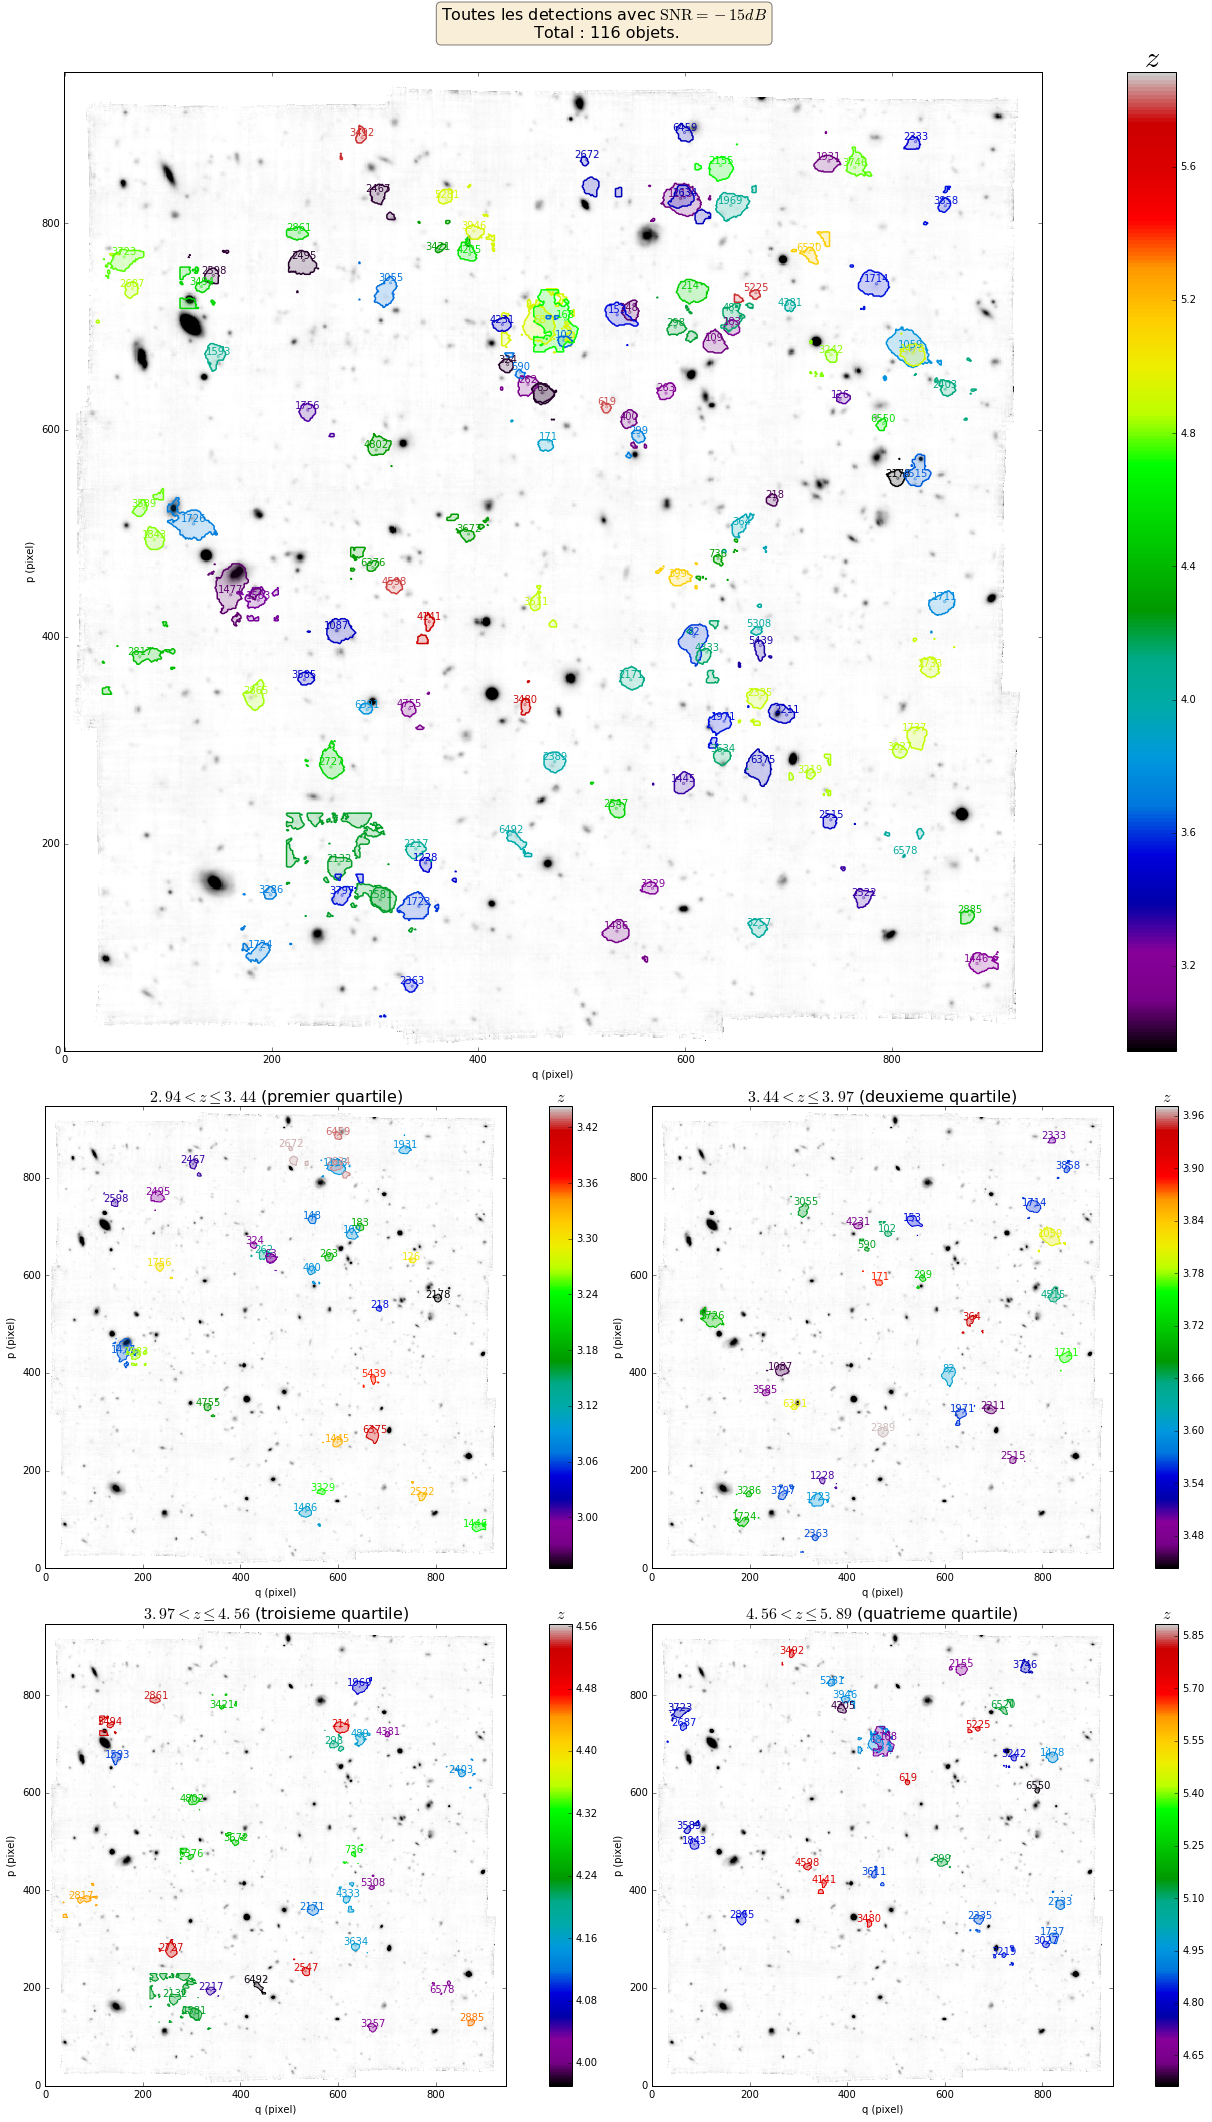

In [115]:
import numpy.ma as ma
import matplotlib

im_cube = Image('data/IMAGE_UDF-MOSAIC.fits')
cm_gr = plt.cm.gray_r
cm_gr.set_bad('w')

fig = plt.figure(figsize=(17,30))
cm_r = plt.cm.nipy_spectral
decal = 25
shapemax = np.array([im_cube.data.data.shape[0]+2*decal, im_cube.data.data.shape[1]+2*decal])


plt.subplot(4,2,(1,4))
zmin_tout = np.min(listez)#cat_lya['Z_MUSE'].min()
zmax_tout = np.max(listez)+0.1#cat_lya['Z_MUSE'].max()+0.1


dumb = zmin_tout * np.ones_like(im_cube.data.data) ; dumb[0,0] = zmax_tout
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=30)
im_cube.plot(vmin=0,vmax=5,cmap='gray_r')


#zrange = np.array([zmin_tout,3.4,3.75,5,zmax_tout])
zrange = np.percentile(listez,(0,25,50,75,100)) ; zrange[-1] +=0.1

ax = plt.subplot(4,2,5)
dumb = zrange[0] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[1]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap=cm_gr)
plt.title('$%.2f < z \leq %.2f$ (premier quartile)'%(zrange[0],zrange[1]),fontsize=16)


ax = plt.subplot(4,2,6)
dumb = zrange[1] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[2]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap=cm_gr)
plt.title('$%.2f < z \leq %.2f$ (deuxieme quartile)'%(zrange[1],zrange[2]),fontsize=16)

ax = plt.subplot(4,2,7)
dumb = zrange[2] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[3]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap=cm_gr)
plt.title('$%.2f < z \leq %.2f$ (troisieme quartile)'%(zrange[2],zrange[3]),fontsize=16)

ax = plt.subplot(4,2,8)
dumb = zrange[3] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[4]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap=cm_gr)
plt.title('$%.2f < z \leq %.2f$ (quatrieme quartile)'%(zrange[3],zrange[4]),fontsize=16)

cm = matplotlib.cm.get_cmap('nipy_spectral')

wcs_ref = im_cube.wcs

nb_obj = 0

for src in sourcelist:
    try:



        image_tout = toutes_im[str(src.id)]
        z = src.z[0][0]

        znorm = (z-zmin_tout)/(zmax_tout-zmin_tout)

        col = cm(znorm)

        ax=plt.subplot(4,2,(1,4))
        cat[cat['ID']==src.id].plot_id(ax,im_cube.wcs,col=col)
        ax.contourf(image_tout,1, colors=(cm(znorm),),alpha=0.20)
        ax.contour(image_tout.data,1, colors=(cm(znorm),),linewidths=1.5)


        # plot sous bande

        #z = src.z[0][0]

        if z <= zrange[1]:
            ax=plt.subplot(4,2,5)
            zmin = zrange[0]
            zmax = zrange[1]
        elif z > zrange[1] and z<=zrange[2]:
            ax=plt.subplot(4,2,6)
            zmin = zrange[1]
            zmax = zrange[2]

        elif z > zrange[2] and z<=zrange[3]:
            ax=plt.subplot(4,2,7)
            zmin = zrange[2]
            zmax = zrange[3]
        elif z > zrange[3]:
            ax=plt.subplot(4,2,8)
            zmin = zrange[3]
            zmax = zrange[4]

        znorm = (z-zmin)/(zmax-zmin)
        col = cm(znorm)
        cat[cat['ID']==src.id].plot_id(ax,im_cube.wcs,col=col)

        #print znorm
        ax.contourf(image_tout,1, colors=(cm(znorm),),alpha=0.30)
        ax.contour(image_tout.data,1, colors=(cm(znorm),))

        nb_obj+=1
    except:
        pass    
    
    
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
texte = 'Toutes les detections avec $\mathrm{SNR} = -15dB$ \n Total : %.0f objets.'%nb_obj
plt.suptitle(texte, bbox=props,fontsize=16)    
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig('./data/mosaic_lya_sources/synth_all.pdf')

In [90]:
## Comptage des détections, non-détections...

sourcelist = list()

listez = list()
liste_id = cat_lya[id_nobor==0]['ID']

nb_obj_conf_ok = 0
nb_obj_conf_non_ok = 0
nb_obj = 0

for id in cat_lya['ID']:
    try:
        if id not in listeciel:
            if id not in listeechec:
                src= Source.from_file('./data/udf10_lya_sources_v0/udf10_'+str(id)+'.fits')
                im = src.images['SEG_HMF']
                
                catloc= cat_lya[cat_lya['ID']==id]
                confid = catloc['CONFID'][0]
                
                nb_obj+=1
                if confid > 1:
                    nb_obj_conf_ok +=1
                elif confid==1:
                    nb_obj_conf_non_ok +=1

    except:
        pass

In [65]:
nb_obj_total = cat_lya['ID'].size
nb_obj_bord = cat_lya[id_nobor==0]['ID'].size
nb_obj_ciel = len(listeciel)
nb_obj_traite = 81#nb_obj_total - nb_obj_bord - nb_obj_ciel - nb_obj_echec
nb_obj_echec = nb_obj_total - nb_obj_bord - nb_obj_ciel - nb_obj_traite#len(listeechec)
print nb_obj_total,nb_obj_bord,nb_obj_ciel,nb_obj_echec, nb_obj_traite
print 100*np.array([nb_obj_total,nb_obj_bord,nb_obj_ciel,nb_obj_echec, nb_obj_traite])/float(nb_obj_total)

183 49 15 38 81
[ 100.           26.77595628    8.19672131   20.76502732   44.26229508]


In [112]:
total_conf_non_ok = cat_lya[cat_lya['CONFID']==1]['ID'].shape[0]
compl_conf_non_ok = 100*float(nb_obj_conf_non_ok)/total_conf_non_ok

total_conf_ok = cat_lya[cat_lya['CONFID']>1]['ID'].shape[0]
compl_conf_ok = 100*float(nb_obj_conf_ok)/total_conf_ok

total = cat_lya['ID'].shape[0]
compl_total = 100*float(nb_obj)/total

print 'Nb objets traites en tout :       %.0f / %.0f soit %.2f p. de completion'%(nb_obj,total,compl_total)
print 'Nb objets traites avec conf > 1 : %.0f / %.0f soit %.2f p. de completion'%(nb_obj_conf_ok, total_conf_ok, compl_conf_ok )
print 'Nb objets traites avec conf = 1 : %.0f / %.0f soit %.2f p. de completion'%(nb_obj_conf_non_ok, total_conf_non_ok,compl_conf_non_ok)

# Nb. Catégoriser les irrécupérables de résidus du ciel des autres !

Nb objets traites en tout :       111 / 183 soit 60.66 p. de completion
Nb objets traites avec conf > 1 : 107 / 157 soit 68.15 p. de completion
Nb objets traites avec conf = 1 : 4 / 26 soit 15.38 p. de completion


In [128]:
sourcelist = list()
numobj = 0

for id in liste_ok:
    try:
        src= Source.from_file('./data/udf10_lya_sources_v0/udf10_'+str(id)+'.fits')
        #if id not in liste_obj_bor:
        sourcelist.append(src)
        numobj+=1

    except:
        pass
print numobj

67


In [307]:
longueurs

array([], dtype=float64)

In [53]:
src.dec

-27.78132311578793

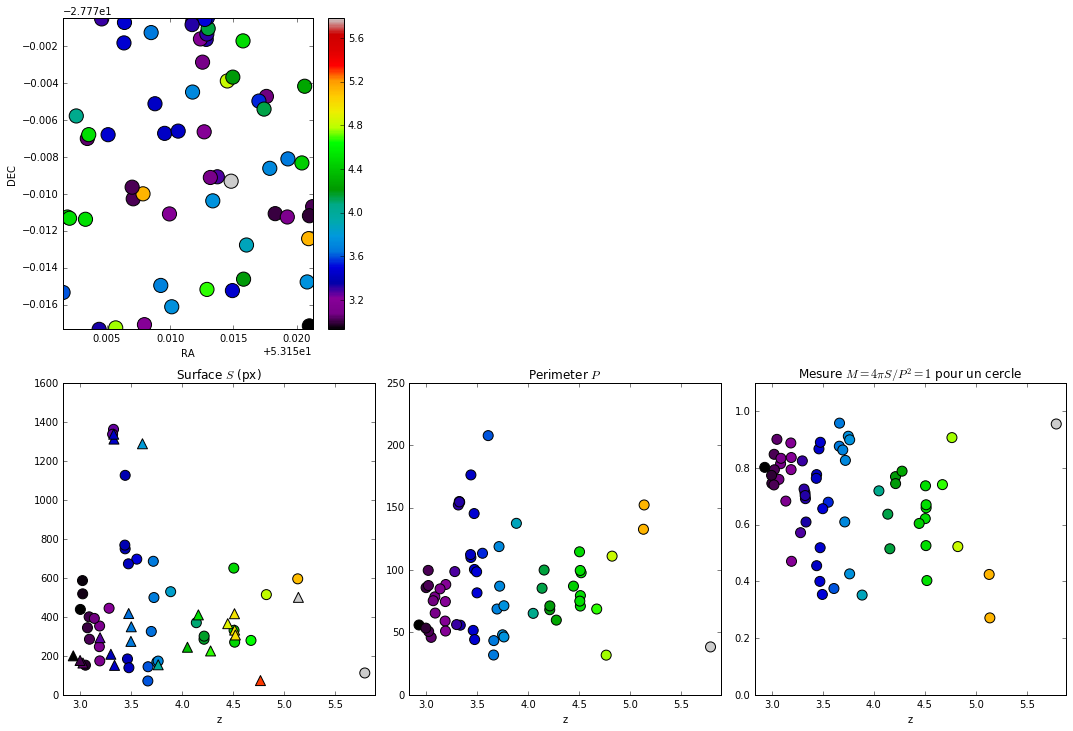

In [153]:
#
#plt.subplot(nb_li,nb_col,2*nb_col+1)
#plt.scatter(ras,surfaces, c=redshifts,s=100); plt.spectral()
#plt.xlabel('RA'); plt.title('Surface $S$ (px)')
#plt.ylim(0,None) ; plt.xlim(ras.min(),ras.max())
#
#plt.subplot(nb_li,nb_col,2*nb_col+2)
#plt.scatter(ras,perims, c=redshifts,s=100); plt.spectral()
#plt.xlabel('RA'); plt.title('Perimeter $P$')
#plt.ylim(0,None) ; plt.xlim(ras.min(),ras.max())
#
#plt.subplot(nb_li,nb_col,2*nb_col+3)
#plt.scatter(ras,mes, c=redshifts,s=100); plt.spectral()
#plt.xlabel('RA'); plt.title('Mesure $M=4\pi S / P^2 = 1$ pour un cercle')
#plt.ylim(0,None) ; plt.xlim(ras.min(),ras.max())
#
#
#
#plt.subplot(nb_li,nb_col,3*nb_col+1)
#plt.scatter(decs,surfaces, c=redshifts,s=100); plt.spectral()
#plt.xlabel('DEC'); plt.title('Surface $S$ (px)')
#plt.ylim(0,None) ; plt.xlim(decs.min(),decs.max())
#
#plt.subplot(nb_li,nb_col,3*nb_col+2)
#plt.scatter(decs,perims, c=redshifts,s=100); plt.spectral()
#plt.xlabel('DEC'); plt.title('Perimeter $P$')
#plt.ylim(0,None) ; plt.xlim(decs.min(),decs.max())
#
#plt.subplot(nb_li,nb_col,3*nb_col+3)
#plt.scatter(decs,mes, c=redshifts,s=100); plt.spectral()
#plt.xlabel('DEC'); plt.title('Mesure $M=4\pi S / P^2 = 1$ pour un cercle')
#plt.ylim(0,None) ; plt.xlim(decs.min(),decs.max())
#
#plt.subplot(nb_li,nb_col,5)
#plt.plot(ras,mes,'o')
#plt.xlabel('RA'); plt.title('Mesure $M$')
#plt.ylim(0,None) ; #plt.xlim(zmin,zmax)
#
#
#
##plt.subplot(nb_li,nb_col,4)
##plt.plot(redshifts,excen,'o')
##plt.xlabel('z'); plt.title('Eccentricity (ratio petit axe/grand axe)')
##plt.ylim(0,None) ; plt.xlim(zmin,zmax)
#
#
#
#plt.subplot(nb_li,nb_col,7)
#plt.plot(redshifts,ras,'o')
#plt.xlabel('z'); plt.title('RA')
#plt.xlim(zmin,zmax)
#
#plt.subplot(nb_li,nb_col,8)
#plt.plot(redshifts,decs,'o')
#plt.xlabel('z'); plt.title('DEC')
#plt.xlim(zmin,zmax)
#

plt.tight_layout()

/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 61 but corresponding boolean dimension is 62
  if __name__ == '__main__':
/home/miv/courbot/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 61 but corresponding boolean dimension is 62
  from IPython.kernel.zmq import kernelapp as app


IndexError: index 61 is out of bounds for axis 1 with size 61

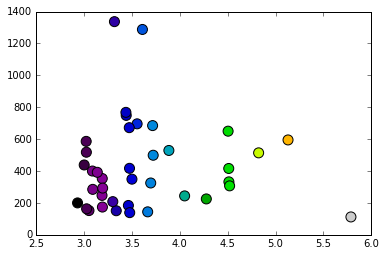

In [145]:
plt.scatter(redshifts[ind_bords==0],surfaces[ind_bords==0], c=redshifts[ind_bords==0],s=100); plt.spectral()
plt.scatter(redshifts[ind_bords==1],surfaces[ind_bords==1], c=redshifts[ind_bords==1],s=100,marker='^'); plt.spectral()

In [147]:
redshifts.shape

(61,)

[-27.78132312  53.15206405]
[[  20.  283.]]
85.9116882454
438.0
0.424659352542


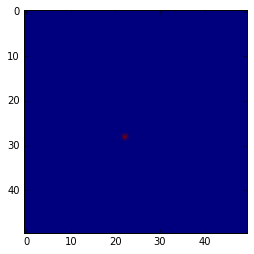

In [66]:
import scipy.ndimage.morphology as morph
im = sourcelist[1].images['SEG_HMF'].data>0

wcs = sourcelist[1].images['SEG_HMF'].wcs
dec_ra = np.array([src.dec,src.ra])


# a) pixel à 1 au centroide de l'image initiale
center = np.round(measure.regionprops(im)[0].centroid).astype(int)
cpix = np.zeros_like(im)
cpix[center[0],center[1]] = 1

# b) on ne garde dans la segmentation que les pixels connexes au pixel central
im2 = morph.binary_propagation(cpix,mask=im)

       
print dec_ra
print wcs.sky2pix(dec_ra)

props = measure.regionprops(im2)[0]
print props.perimeter
print props.area
print props.eccentricity

plt.imshow(cpix)
#sourcelist[1].images['SEG_HMF'].plot()

(array([  1.,   2.,  10.,   7.,   6.,   4.,   1.,   8.,   3.,   4.,  10.,
          3.,   2.,   3.,   3.]),
 array([ 0.15945563,  0.21270817,  0.26596071,  0.31921325,  0.37246579,
         0.42571832,  0.47897086,  0.5322234 ,  0.58547594,  0.63872848,
         0.69198102,  0.74523355,  0.79848609,  0.85173863,  0.90499117,
         0.95824371]),
 <a list of 15 Patch objects>)

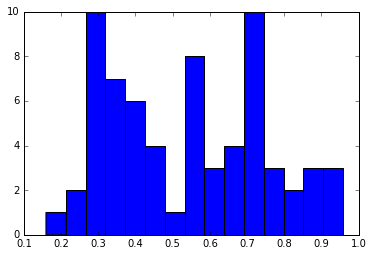

In [46]:
plt.hist(mes,15)

In [23]:
########################################
# Calcul du RSB
########################################

rsbarr = np.array([])


for id in cat_lya['ID']:
    try:
        src= Source.from_file('./data/udf10_lya_sources_v0/udf10_'+str(id)+'.fits')

        
        spectre = src.spectra['SP_SEM'].data.data
        Lambda = spectre.size
        sigma = src.sig_sem
        
        rsb_dec = np.linalg.norm(spectre)**2/(Lambda*sigma**2)
        rsb = 10*np.log10(rsb_dec)
        
        rsbarr=np.append(rsbarr, rsb)
    except:
        pass

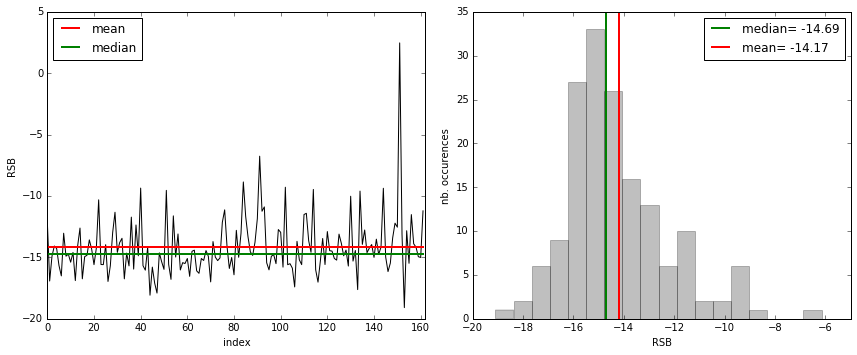

In [56]:
plt.figure(figsize=(12,5))

med = np.median(rsbarr)
mea = np.mean(rsbarr)

plt.subplot(121)
plt.plot(rsbarr,'k')
plt.plot(mea*np.ones_like(rsbarr),'r',label='mean',linewidth=2)
plt.plot(med*np.ones_like(rsbarr),'g',label='median',linewidth=2)
plt.legend(loc='best')
plt.xlabel('index') ; plt.ylabel('RSB'); plt.xlim(0,rsbarr.size)
plt.subplot(122)
plt.hist(rsbarr,30,facecolor='k',alpha=0.25)
plt.plot( (med,med), (0,35) ,'g',label='median= %.2f'%med,linewidth=2)
plt.plot( (mea,mea), (0,35) ,'r',label='mean= %.2f'%mea,linewidth=2)
plt.legend(loc='best')
plt.xlabel('RSB'); plt.ylabel('nb. occurences')
plt.xlim(-20,-5)
plt.tight_layout()

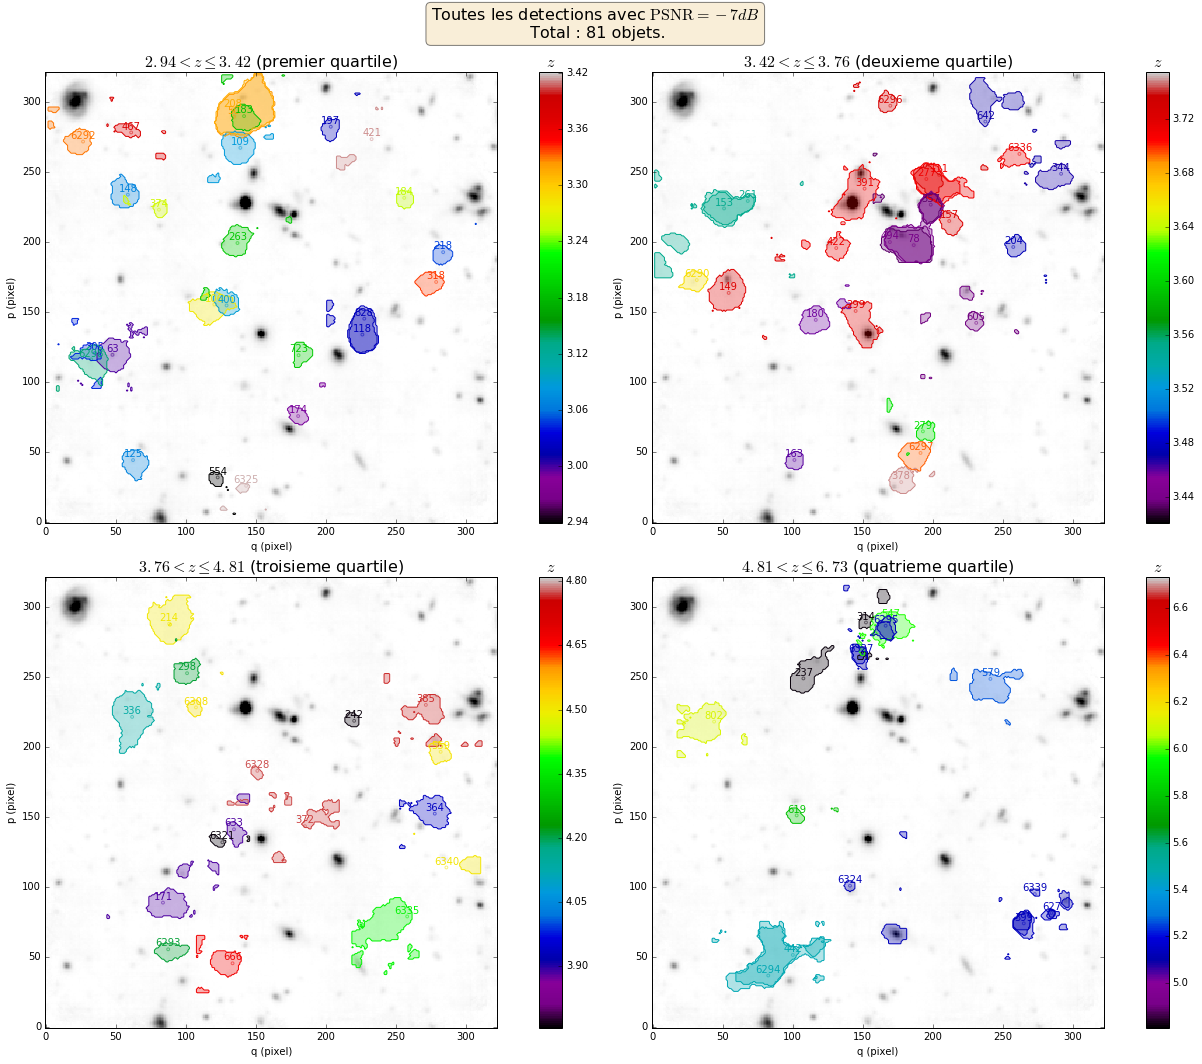

In [38]:
import numpy.ma as ma
fig = plt.figure(figsize=(17,15))

zmin_tout = cat_lya['Z_MUSE'].min()
zmax_tout = cat_lya['Z_MUSE'].max()+0.1

#zrange = np.array([zmin_tout,3.4,3.75,5,zmax_tout])
zrange = np.percentile(listez,(0,25,50,75,100)) ; zrange[-1] +=0.1
ax = plt.subplot(2,2,1)
cm_r = plt.cm.nipy_spectral

dumb = zrange[0] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[1]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap='gray_r')
plt.title('$%.2f < z \leq %.2f$ (premier quartile)'%(zrange[0],zrange[1]),fontsize=16)


ax = plt.subplot(2,2,2)
dumb = zrange[1] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[2]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap='gray_r')
plt.title('$%.2f < z \leq %.2f$ (deuxieme quartile)'%(zrange[1],zrange[2]),fontsize=16)

ax = plt.subplot(2,2,3)
dumb = zrange[2] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[3]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap='gray_r')
plt.title('$%.2f < z \leq %.2f$ (troisieme quartile)'%(zrange[2],zrange[3]),fontsize=16)

ax = plt.subplot(2,2,4)
dumb = zrange[3] * np.ones_like(im_cube.data.data) ; dumb[0,0] = zrange[4]
plt.imshow(dumb, cmap=cm_r) ; clb = plt.colorbar(fraction=0.046,pad=0.04); clb.ax.set_title('$z$',fontsize=16)
im_cube.plot(vmin=0,vmax=5,cmap='gray_r')
plt.title('$%.2f < z \leq %.2f$ (quatrieme quartile)'%(zrange[3],zrange[4]),fontsize=16)

cm = matplotlib.cm.get_cmap('nipy_spectral')

wcs_ref = im_cube.wcs

nb_obj = 0

for src in sourcelist:
    try:
        im = src.images['SEG_HMF']
        z = src.z[0][0]

        if z <= zrange[1]:
            ax=plt.subplot(2,2,1)
            zmin = zrange[0]
            zmax = zrange[1]
        elif z > zrange[1] and z<=zrange[2]:
            ax=plt.subplot(2,2,2)
            zmin = zrange[1]
            zmax = zrange[2]

        elif z > zrange[2] and z<=zrange[3]:
            ax=plt.subplot(2,2,3)
            zmin = zrange[2]
            zmax = zrange[3]
        elif z > zrange[3]:
            ax=plt.subplot(2,2,4)
            zmin = zrange[3]
            zmax = zrange[4]

        start_radec, end_radec = im.get_start(), im.get_end()

        #print start_radec
        start_pix = wcs_ref.sky2pix(start_radec)[0].astype(int)
        end_pix = start_pix + im.data.data.shape
        #print start_pix
        #print end_pix
        if src.id not in listeciel:
            if src.id not in listeechec:
                image_tout = np.zeros_like(im_cube.data.data)
                image_tout[start_pix[0]:end_pix[0], start_pix[1]:end_pix[1]] = im.data.data
                image_tout = ma.masked_array(image_tout,mask=image_tout==0)

                znorm = (z-zmin)/(zmax-zmin)
                col = cm(znorm)
                cat[cat['ID']==src.id].plot_id(ax,im_cube.wcs,col=col)

                #print znorm
                plt.contourf(image_tout,1, colors=(cm(znorm),),alpha=0.30)
                plt.contour(image_tout.data,1, colors=(cm(znorm),))

                nb_obj+=1
    except:
        pass

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
texte = 'Toutes les detections avec $\mathrm{PSNR} = -7dB$ \n Total : %.0f objets.'%nb_obj
plt.suptitle(texte, bbox=props,fontsize=16)    
    
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.savefig('./data/udf10_lya_sources_v0/synth_all.pdf')

In [222]:
redshifts = np.array([])
surfaces = np.array([0])
for src in sourcelist:
    if src.id not in listeciel:

            r = np.array([src.z[0][0]])
            redshifts = np.append(redshifts,r)



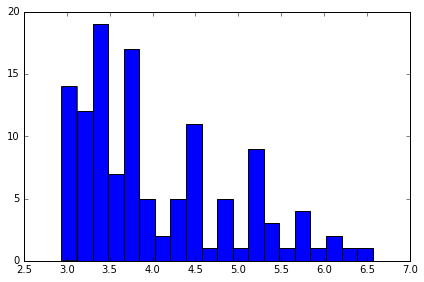

In [231]:
plt.hist(redshifts,20); plt.tight_layout()

In [77]:
cat_lya['Z_MUSE'].min()

2.9297

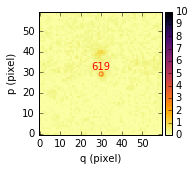

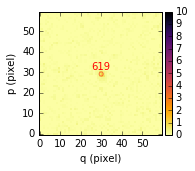

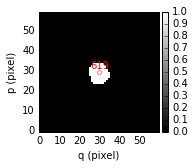

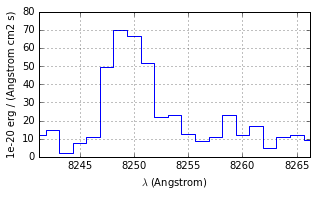

In [88]:
import matplotlib
matplotlib.use('pgf')
pgf_pdflatex = {"pgf.texsystem":"pdflatex"}
matplotlib.rcParams.update(pgf_pdflatex)
import matplotlib.pyplot as plt

src = sourcelist[-4]
cm = plt.cm.inferno_r


plt.figure(figsize=(2.8,2.8))
ax=plt.subplot(111)
im_wh = src.images['WHITE']
cat2=cat.select(im_wh.wcs)
cat_lya2=cat_lya.select(im_wh.wcs)
ecart_z = np.abs(cat_lya2['Z_MUSE']-src.z[0][0])
cat_lya2=cat_lya2[ecart_z < 0.05]


im_wh.plot(cmap=cm,colorbar='v',vmin=0,vmax=10)
#cat2.plot_id(ax,im_wh.wcs)
cat_lya2.plot_id(ax,im_wh.wcs,col='red')
plt.xlabel(''); plt.ylabel(''); plt.tight_layout()
plt.savefig('./figures/obj619_wh.pgf')


plt.figure(figsize=(2.8,2.8))
ax=plt.subplot(111)
im_wh2 = src.images['WHITE_MS']
cat2=cat.select(im_wh.wcs)
cat_lya2=cat_lya.select(im_wh.wcs)
ecart_z = np.abs(cat_lya2['Z_MUSE']-src.z[0][0])
cat_lya2=cat_lya2[ecart_z < 0.05]


im_wh2.plot(cmap=cm,colorbar='v',vmin=0,vmax=10)
#cat2.plot_id(ax,im_wh.wcs)
cat_lya2.plot_id(ax,im_wh.wcs,col='red')
plt.xlabel(''); plt.ylabel(''); plt.tight_layout()
plt.savefig('./figures/obj619_wh_ms.pgf')

plt.figure(figsize=(2.8,2.8))
ax=plt.subplot(111)

im_seg = src.images['SEG_HMF']
im_seg.data.mask = np.zeros_like(im_seg.data.data)

im_seg.plot(ax=ax,colorbar='v',cmap=plt.cm.gray)

cat_lya2.plot_id(ax,im_seg.wcs,col='red')
plt.xlabel(''); plt.ylabel(''); plt.tight_layout()
plt.savefig('./figures/obj619_seg.pgf')
plt.figure(figsize=(4.5,2.8))
ax=plt.subplot(111)

try:
    sp_sum = src.spectra['SP_SUM_NOMS']
except:
    sp_sum = src.spectra['sp_sum_noms']    

sp_sum.plot()
plt.xlim(sp_sum.get_start(),sp_sum.get_end()) ; plt.grid()
plt.tight_layout()
plt.savefig('./figures/obj619_sp_noms.pgf')




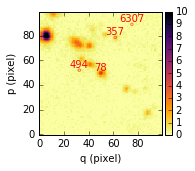

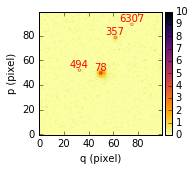

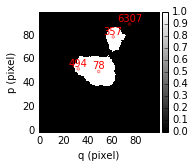

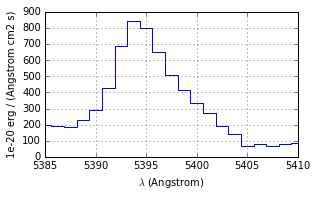

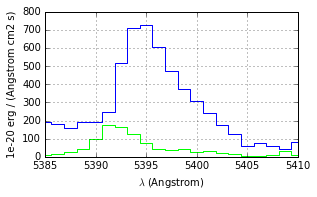

In [89]:
import matplotlib
matplotlib.use('pgf')
pgf_pdflatex = {"pgf.texsystem":"pdflatex"}
matplotlib.rcParams.update(pgf_pdflatex)
import matplotlib.pyplot as plt

src = sourcelist[0]
cm = plt.cm.inferno_r


plt.figure(figsize=(2.8,2.8))
ax=plt.subplot(111)
im_wh = src.images['WHITE']
cat2=cat.select(im_wh.wcs)
cat_lya2=cat_lya.select(im_wh.wcs)
ecart_z = np.abs(cat_lya2['Z_MUSE']-src.z[0][0])
cat_lya2=cat_lya2[ecart_z < 0.05]


im_wh.plot(cmap=cm,colorbar='v',vmin=0,vmax=10)
#cat2.plot_id(ax,im_wh.wcs)
cat_lya2.plot_id(ax,im_wh.wcs,col='red')
plt.xlabel(''); plt.ylabel(''); plt.tight_layout()
plt.savefig('./figures/obj78_wh.pgf')


plt.figure(figsize=(2.8,2.8))
ax=plt.subplot(111)
im_wh2 = src.images['WHITE_MS']
cat2=cat.select(im_wh.wcs)
cat_lya2=cat_lya.select(im_wh.wcs)
ecart_z = np.abs(cat_lya2['Z_MUSE']-src.z[0][0])
cat_lya2=cat_lya2[ecart_z < 0.05]


im_wh2.plot(cmap=cm,colorbar='v',vmin=0,vmax=10)
#cat2.plot_id(ax,im_wh.wcs)
cat_lya2.plot_id(ax,im_wh.wcs,col='red')
plt.xlabel(''); plt.ylabel(''); plt.tight_layout()
plt.savefig('./figures/obj78_wh_ms.pgf')

plt.figure(figsize=(2.8,2.8))
ax=plt.subplot(111)

im_seg = src.images['SEG_HMF']
im_seg.data.mask = np.zeros_like(im_seg.data.data)

im_seg.plot(ax=ax,colorbar='v',cmap=plt.cm.gray)

cat_lya2.plot_id(ax,im_seg.wcs,col='red')
plt.xlabel(''); plt.ylabel(''); plt.tight_layout()
plt.savefig('./figures/obj78_seg.pgf')
plt.figure(figsize=(4.5,2.8))
ax=plt.subplot(111)

try:
    sp_sum = src.spectra['SP_SUM_NOMS']
except:
    sp_sum = src.spectra['sp_sum_noms']    

sp_sum.plot()
plt.xlim(sp_sum.get_start(),sp_sum.get_end()) ; plt.grid()
plt.tight_layout()
plt.savefig('./figures/obj78_sp_noms.pgf')


plt.figure(figsize=(4.5,2.8))
ax=plt.subplot(111)

im2 = im_seg.copy()
num_feat = ndi.label(im_seg.data.data,output=im2.data)
cmap= matplotlib.cm.get_cmap('brg')
for feat in range(1,num_feat+1):
    msk = (im2.data==feat)
    if msk.sum() > 20:
        cubemask = src.cubes['CUBE']
        cubemask.data.mask=msk==0
        cubemask.sum(axis=(1,2)).plot(color=cmap((feat-1.)/float(num_feat-1)))
plt.xlim(sp_sum.get_start(),sp_sum.get_end()) ; plt.grid()               
plt.tight_layout()
plt.savefig('./figures/obj78_sps_noms.pgf')